# Tutorial:  Unstructured Convolutional Autoencoders with Continuous Convolution
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mathLab/PINA/blob/master/tutorials/tutorial4/tutorial.ipynb)

In this tutorial, we will show how to use the Continuous Convolutional Filter, and how to build common Deep Learning architectures with it. The implementation of the filter follows the original work [*A Continuous Convolutional Trainable Filter for Modelling Unstructured Data*](https://arxiv.org/abs/2210.13416).

First of all we import the modules needed for the tutorial:

In [ ]:
## routine needed to run the notebook on Google Colab
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    !pip install "pina-mathlab[tutorial]"

import torch
import matplotlib.pyplot as plt
import torchvision  # for MNIST dataset
import warnings

from pina import Trainer
from pina.problem.zoo import SupervisedProblem
from pina.solver import SupervisedSolver
from pina.trainer import Trainer
from pina.model.block import ContinuousConvBlock
from pina.model import FeedForward  # for building AE and MNIST classification

warnings.filterwarnings("ignore")

##  Tutorial Structure

The tutorial is structured as follows:

- [🔹 Continuous Filter Background](#continuous-filter-background):  
  Understand how the convolutional filter works and how to use it.

- [🔹 Building a MNIST Classifier](#building-a-mnist-classifier):  
  Learn how to build a simple classifier using the MNIST dataset, and how to combine a continuous convolutional layer with a feedforward neural network.

- [🔹 Building a Continuous Convolutional Autoencoder](#building-a-continuous-convolutional-autoencoder):  
  Explore how to use the continuous filter to work with unstructured data for autoencoding and up-sampling.


## Continuous Filter Background

As reported by the authors in the original paper, in contrast to discrete convolution, **continuous convolution** is mathematically defined as:

$$
    \mathcal{I}_{\rm{out}}(\mathbf{x}) = \int_{\mathcal{X}}  \mathcal{I}(\mathbf{x} + \mathbf{\tau}) \cdot \mathcal{K}(\mathbf{\tau}) d\mathbf{\tau},
$$

where:
- $\mathcal{K} : \mathcal{X} \rightarrow \mathbb{R}$ is the **continuous filter** function,
- $\mathcal{I} : \Omega \subset \mathbb{R}^N \rightarrow \mathbb{R}$ is the input function.

The **continuous filter function** is approximated using a **FeedForward Neural Network**, which is **trainable** during the training phase. The way in which the integral is approximated can vary. In the **PINA** framework, we approximate it using a simple sum, as suggested by the authors. Thus, given the points $\{\mathbf{x}_i\}_{i=1}^{n}$ in $\mathbb{R}^N$ mapped onto the filter domain $\mathcal{X}$, we approximate the equation as:

$$
    \mathcal{I}_{\rm{out}}(\mathbf{\tilde{x}}_i) = \sum_{{\mathbf{x}_i}\in\mathcal{X}}  \mathcal{I}(\mathbf{x}_i + \mathbf{\tau}) \cdot \mathcal{K}(\mathbf{x}_i),
$$

where $\mathbf{\tau} \in \mathcal{S}$, with $\mathcal{S}$ being the set of available strides, represents the current stride position of the filter. The $\mathbf{\tilde{x}}_i$ points are obtained by taking the **centroid** of the filter position mapped onto the domain $\Omega$.

### Working with the Continuous Filter

From the above definition, what is needed is:
1. A **domain** and a **function** defined on that domain (the input),
2. A **stride**, corresponding to the positions where the filter needs to be applied (this is the `stride` variable in `ContinuousConv`),
3. The **filter's rectangular domain**, which corresponds to the `filter_dim` variable in `ContinuousConv`.

### Input Function

The input function for the continuous filter is defined as a tensor of shape:

$$[B \times N_{\text{in}} \times N \times D]$$

where:
- $B$ is the **batch size**,
- $N_{\text{in}}$ is the number of input fields,
- $N$ is the number of points in the mesh,
- $D$ is the dimension of the problem. 

In particular:
- $D$ represents the **number of spatial variables** + 1. The last column must contain the field value. For example, for 2D problems, $D=3$ and the tensor will look like `[first coordinate, second coordinate, field value]`.
- $N_{\text{in}}$ represents the number of vectorial functions presented. For example, a vectorial function $f = [f_1, f_2]$ will have $N_{\text{in}}=2$.

#### Example: Input Function for a Vectorial Field

Let’s see an example to clarify the idea. Suppose we wish to create the function:

$$
f(x, y) = [\sin(\pi x) \sin(\pi y), -\sin(\pi x) \sin(\pi y)] \quad (x,y)\in[0,1]\times[0,1]
$$

We can do this with a **batch size** equal to 1. This function consists of two components (vectorial field), so $N_{\text{in}}=2$. For each $(x,y)$ pair in the domain $[0,1] \times [0,1]$, we will compute the corresponding field values:

1. $\sin(\pi x) \sin(\pi y)$
2. $-\sin(\pi x) \sin(\pi y)$

In [2]:
# batch size fixed to 1
batch_size = 1

# points in the mesh fixed to 200
N = 200

# vectorial 2 dimensional function, number_input_fields=2
number_input_fields = 2

# 2 dimensional spatial variables, D = 2 + 1 = 3
D = 3

# create the function f domain as random 2d points in [0, 1]
domain = torch.rand(size=(batch_size, number_input_fields, N, D - 1))
print(f"Domain has shape: {domain.shape}")

# create the functions
pi = torch.acos(torch.tensor([-1.0]))  # pi value
f1 = torch.sin(pi * domain[:, 0, :, 0]) * torch.sin(pi * domain[:, 0, :, 1])
f2 = -torch.sin(pi * domain[:, 1, :, 0]) * torch.sin(pi * domain[:, 1, :, 1])

# stacking the input domain and field values
data = torch.empty(size=(batch_size, number_input_fields, N, D))
data[..., :-1] = domain  # copy the domain
data[:, 0, :, -1] = f1  # copy first field value
data[:, 1, :, -1] = f1  # copy second field value
print(f"Filter input data has shape: {data.shape}")

Domain has shape: torch.Size([1, 2, 200, 2])
Filter input data has shape: torch.Size([1, 2, 200, 3])


### Stride

The **stride** is passed as a dictionary `stride` that dictates where the filter should move. Here's an example for the domain $[0,1] \times [0,5]$:

```python
# stride definition
stride = {"domain": [1, 5],
          "start": [0, 0],
          "jump": [0.1, 0.3],
          "direction": [1, 1],
          }
```
This tells the filter:
1. `domain`: The domain over which the filter operates. In this case, the filter works over the $[0,1] \times [0,5]$ domain. The minimum value is always zero, and the maximum value is specified by the user.
2. `start`: The starting position of the filter's centroid. In this example, the filter starts at the position $(0, 0)$.
3. `jump`: The steps or jumps of the filter’s centroid to the next position. In this example, the filter moves by $(0.1, 0.3)$ along the x and y axes respectively.
4. `direction`: The directions of the jumps for each coordinate. A value of 1 indicates the filter moves right, 0 means no movement, and -1 indicates the filter moves left with respect to its current position.

### Filter definition

Now that we have defined the stride, we can move on to construct the continuous filter.
Let’s assume we want the output to contain only one field, and we will set the filter dimension to be $[0.1, 0.1]$.

In [3]:
# filter dim
filter_dim = [0.1, 0.1]

# stride
stride = {
    "domain": [1, 1],
    "start": [0, 0],
    "jump": [0.08, 0.08],
    "direction": [1, 1],
}

# creating the filter
cConv = ContinuousConvBlock(
    input_numb_field=number_input_fields,
    output_numb_field=1,
    filter_dim=filter_dim,
    stride=stride,
)

That's it! In just one line of code, we have successfully created the continuous convolutional filter. By default, the `pina.model.FeedForward` neural network is initialized, which can be further customized according to your needs.

Additionally, if the mesh does not change during training, we can set the `optimize` flag to `True` to leverage optimizations for efficiently finding the points to convolve. This feature helps in improving the performance by reducing redundant calculations when the mesh remains constant.

In [4]:
# creating the filter + optimization
cConv = ContinuousConvBlock(
    input_numb_field=number_input_fields,
    output_numb_field=1,
    filter_dim=filter_dim,
    stride=stride,
    optimize=True,
)

Let's try to do a forward pass:

In [5]:
print(f"Filter input data has shape: {data.shape}")

# input to the filter
output = cConv(data)

print(f"Filter output data has shape: {output.shape}")

Filter input data has shape: torch.Size([1, 2, 200, 3])
Filter output data has shape: torch.Size([1, 1, 169, 3])


If you don't want to use the default `FeedForward` neural network, you can pass a custom PyTorch model by specifying it in the `model` keyword. Here's an example of how to do it:

In [6]:
class SimpleKernel(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Linear(2, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, 1),
        )

    def forward(self, x):
        return self.model(x)


cConv = ContinuousConvBlock(
    input_numb_field=number_input_fields,
    output_numb_field=1,
    filter_dim=filter_dim,
    stride=stride,
    optimize=True,
    model=SimpleKernel,
)

Notice that we pass the **class** of the model and not an already built object! This is important because the `ContinuousConv` filter will automatically instantiate the model class when needed during training. 

## Building a MNIST Classifier

Let's see how we can build a MNIST classifier using a continuous convolutional filter. We will use the MNIST dataset from PyTorch. In order to keep small training times we use only 6000 samples for training and 1000 samples for testing.

In [7]:
numb_training = 6000  # get just 6000 images for training
numb_testing = 1000  # get just 1000 images for training
seed = 111  # for reproducibility
batch_size = 8  # setting batch size

# setting the seed
torch.manual_seed(seed)

# downloading the dataset
train_data = torchvision.datasets.MNIST(
    "./tutorial_logs/",
    download=True,
    train=False,
    transform=torchvision.transforms.Compose(
        [
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,)),
        ]
    ),
)

Now, let's proceed to build a simple classifier for the MNIST dataset. The MNIST dataset consists of vectors with the shape `[batch, 1, 28, 28]`, but we can treat them as field functions where each pixel at coordinates $i,j$ corresponds to a point in a $[0, 27] \times [0, 27]$ domain. The pixel values represent the field values.

To use the continuous convolutional filter, we need to transform the regular tensor into a format compatible with the filter. Here's a function that will help with this transformation:

In [8]:
def transform_input(x):
    batch_size = x.shape[0]
    dim_grid = tuple(x.shape[:-3:-1])

    # creating the n dimensional mesh grid for a single channel image
    values_mesh = [torch.arange(0, dim).float() for dim in dim_grid]
    mesh = torch.meshgrid(values_mesh)
    coordinates_mesh = [m.reshape(-1, 1).to(x.device) for m in mesh]
    coordinates = (
        torch.cat(coordinates_mesh, dim=1)
        .unsqueeze(0)
        .repeat((batch_size, 1, 1))
        .unsqueeze(1)
    )

    return torch.cat((coordinates, x.flatten(2).unsqueeze(-1)), dim=-1)

We can now build a simple classifier! We will use just one convolutional filter followed by a feedforward neural network

In [9]:
# setting the seed
torch.manual_seed(seed)


class ContinuousClassifier(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # number of classes for classification
        numb_class = 10

        # convolutional block
        self.convolution = ContinuousConvBlock(
            input_numb_field=1,
            output_numb_field=4,
            stride={
                "domain": [27, 27],
                "start": [0, 0],
                "jumps": [4, 4],
                "direction": [1, 1.0],
            },
            filter_dim=[4, 4],
            optimize=True,
        )
        # feedforward net
        self.nn = FeedForward(
            input_dimensions=196,
            output_dimensions=numb_class,
            layers=[120, 64],
            func=torch.nn.ReLU,
        )

    def forward(self, x):
        # transform input + convolution
        x = transform_input(x)
        x = self.convolution(x)
        # feed forward classification
        return self.nn(x[..., -1].flatten(1))

We now aim to solve a classification problem. For this we will use the `SupervisedSolver` and the `SupervisedProblem`. The input of the supervised problems are the images, while the output the corresponding class. We will train with `CrossEntropyLoss`.

In [10]:
# setting the problem
problem = SupervisedProblem(
    input_=train_data.train_data.unsqueeze(1),  # adding channel dimension
    output_=train_data.train_labels,
)

# setting the solver
solver = SupervisedSolver(
    problem=problem,
    model=ContinuousClassifier(),
    loss=torch.nn.CrossEntropyLoss(),
    use_lt=False,
)

# setting the trainer
trainer = Trainer(
    solver=solver,
    max_epochs=1,
    accelerator="cpu",
    enable_model_summary=False,
    train_size=0.7,
    val_size=0.1,
    test_size=0.2,
    batch_size=64,
)
trainer.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


Let's see the performance on the test set!

In [11]:
correct = 0
total = 0
trainer.data_module.setup("test")
with torch.no_grad():
    for data in trainer.data_module.test_dataloader():
        test_data = data["data"]
        images, labels = test_data["input"], test_data["target"]
        # calculate outputs by running images through the network
        outputs = solver(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the network on the test images: {(correct / total):.3%}")

Accuracy of the network on the test images: 81.550%


As we can see we have very good performance for having trained only for 1 epoch! Nevertheless, we are still using structured data... Let's see how we can build an autoencoder for unstructured data now.

## Building a Continuous Convolutional Autoencoder

As a toy problem, we will now build an autoencoder for the function \( f(x, y) = \sin(\pi x) \sin(\pi y) \) on the unit circle domain centered at \( (0.5, 0.5) \). We will also explore the ability to up-sample the results (once trained) without needing to retrain the model. To begin, we'll generate the input data for the function. First, we will use a mesh of 100 points and visualize the input function. Here’s how to proceed:

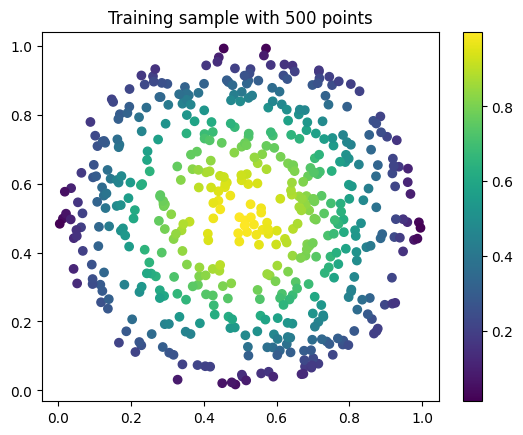

In [12]:
# create inputs
def circle_grid(N=100):
    """Generate points withing a unit 2D circle centered in (0.5, 0.5)

    :param N: number of points
    :type N: float
    :return: [x, y] array of points
    :rtype: torch.tensor
    """

    PI = torch.acos(torch.zeros(1)).item() * 2
    R = 0.5
    centerX = 0.5
    centerY = 0.5

    r = R * torch.sqrt(torch.rand(N))
    theta = torch.rand(N) * 2 * PI

    x = centerX + r * torch.cos(theta)
    y = centerY + r * torch.sin(theta)

    return torch.stack([x, y]).T


# create the grid
grid = circle_grid(500)

# create input
input_data = torch.empty(size=(1, 1, grid.shape[0], 3))
input_data[0, 0, :, :-1] = grid
input_data[0, 0, :, -1] = torch.sin(pi * grid[:, 0]) * torch.sin(
    pi * grid[:, 1]
)

# visualize data
plt.title("Training sample with 500 points")
plt.scatter(grid[:, 0], grid[:, 1], c=input_data[0, 0, :, -1])
plt.colorbar()
plt.show()

Now, let's create a simple autoencoder using the continuous convolutional filter. Since the data is inherently unstructured, a standard convolutional filter may not be effective without some form of projection or interpolation. We'll begin by building an `Encoder` and `Decoder` class, and then combine them into a unified `Autoencoder` class.


In [13]:
class Encoder(torch.nn.Module):
    def __init__(self, hidden_dimension):
        super().__init__()

        # convolutional block
        self.convolution = ContinuousConvBlock(
            input_numb_field=1,
            output_numb_field=2,
            stride={
                "domain": [1, 1],
                "start": [0, 0],
                "jumps": [0.05, 0.05],
                "direction": [1, 1.0],
            },
            filter_dim=[0.15, 0.15],
            optimize=True,
        )
        # feedforward net
        self.nn = FeedForward(
            input_dimensions=400,
            output_dimensions=hidden_dimension,
            layers=[240, 120],
        )

    def forward(self, x):
        # convolution
        x = self.convolution(x)
        # feed forward pass
        return self.nn(x[..., -1])


class Decoder(torch.nn.Module):
    def __init__(self, hidden_dimension):
        super().__init__()

        # convolutional block
        self.convolution = ContinuousConvBlock(
            input_numb_field=2,
            output_numb_field=1,
            stride={
                "domain": [1, 1],
                "start": [0, 0],
                "jumps": [0.05, 0.05],
                "direction": [1, 1.0],
            },
            filter_dim=[0.15, 0.15],
            optimize=True,
        )
        # feedforward net
        self.nn = FeedForward(
            input_dimensions=hidden_dimension,
            output_dimensions=400,
            layers=[120, 240],
        )

    def forward(self, weights, grid):
        # feed forward pass
        x = self.nn(weights)
        # transpose convolution
        return torch.sigmoid(self.convolution.transpose(x, grid))

Great! In the `Decoder` class, during the `forward` pass, we used the `.transpose()` method of the `ContinuousConvolution` class. This method takes the `weights` for upsampling and the `grid` on which to perform the upsampling. Now, let's go ahead and build the autoencoder! We'll define the hidden dimension with the `hidden_dimension` variable, and apply the sigmoid function on the output since the field values are constrained within the range $[0, 1]$.

In [14]:
class Autoencoder(torch.nn.Module):
    def __init__(self, hidden_dimension=10):
        super().__init__()

        self.encoder = Encoder(hidden_dimension)
        self.decoder = Decoder(hidden_dimension)

    def forward(self, x):
        # saving grid for later upsampling
        grid = x.clone().detach()
        # encoder
        weights = self.encoder(x)
        # decoder
        out = self.decoder(weights, grid)
        return out

Now, let's proceed with training the autoencoder by minimizing the mean squared error (MSE) loss and optimizing using the Adam optimizer. We'll use the `SupervisedSolver` for the training, and the problem will be defined as a simple problem inherited from `AbstractProblem`.

In [15]:
# define the problem
problem = SupervisedProblem(input_data, input_data)


# define the solver
solver = SupervisedSolver(
    problem=problem,
    model=Autoencoder(),
    loss=torch.nn.MSELoss(),
    use_lt=False,
)

# train
trainer = Trainer(
    solver,
    max_epochs=100,
    accelerator="cpu",
    enable_model_summary=False,  # we train on CPU and avoid model summary at beginning of training (optional)
    train_size=1.0,
    val_size=0.0,
    test_size=0.0,
)
trainer.train()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Now, let's visualize the real solution alongside the autoencoder's reconstruction, displaying them side by side for comparison!

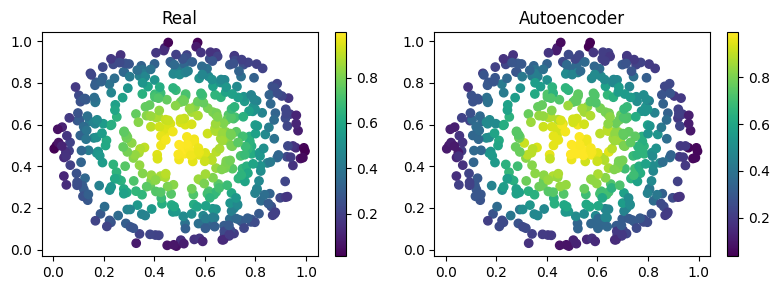

In [16]:
solver.eval()

# get output and detach from computational graph for plotting
output = solver(input_data).detach()

# visualize data
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
pic1 = axes[0].scatter(grid[:, 0], grid[:, 1], c=input_data[0, 0, :, -1])
axes[0].set_title("Real")
fig.colorbar(pic1)
plt.subplot(1, 2, 2)
pic2 = axes[1].scatter(grid[:, 0], grid[:, 1], c=output[0, 0, :, -1])
axes[1].set_title("Autoencoder")
fig.colorbar(pic2)
plt.tight_layout()
plt.show()

As observed, the two solutions are nearly identical! We can also compute the $l_2$ error between the real solution and the autoencoder's reconstruction quite easily:

In [17]:
def l2_error(input_, target):
    return torch.linalg.norm(input_ - target, ord=2) / torch.linalg.norm(
        input_, ord=2
    )


print(f"l2 error: {l2_error(input_data[0, 0, :, -1], output[0, 0, :, -1]):.2%}")

l2 error: 4.78%


The $l_2$ error is approximately $4\%$, which is quite low considering that we only use **one** convolutional layer and a simple feedforward network to reduce the dimension. Now, let's explore some of the unique features of the filter.

### Upsampling with the Filter

Suppose we have a hidden representation and we want to upsample it on a different grid with more points. Let's see how we can achieve that:

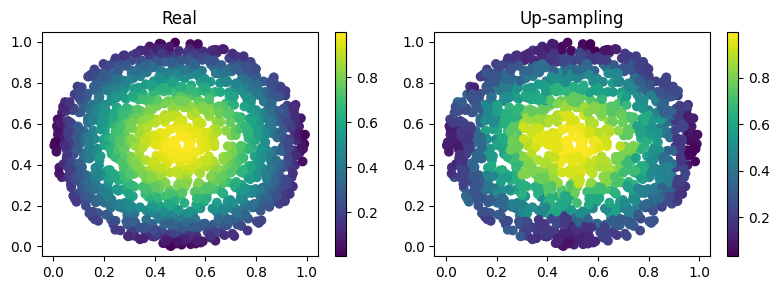

In [18]:
# setting the seed
torch.manual_seed(seed)

grid2 = circle_grid(1500)  # triple number of points
input_data2 = torch.zeros(size=(1, 1, grid2.shape[0], 3))
input_data2[0, 0, :, :-1] = grid2
input_data2[0, 0, :, -1] = torch.sin(pi * grid2[:, 0]) * torch.sin(
    pi * grid2[:, 1]
)

# get the hidden representation from original input
latent = solver.model.encoder(input_data)

# upsample on the second input_data2
output = solver.model.decoder(latent, input_data2).detach()

# show the picture
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))
pic1 = axes[0].scatter(grid2[:, 0], grid2[:, 1], c=input_data2[0, 0, :, -1])
axes[0].set_title("Real")
fig.colorbar(pic1)
plt.subplot(1, 2, 2)
pic2 = axes[1].scatter(grid2[:, 0], grid2[:, 1], c=output[0, 0, :, -1])
axes[1].set_title("Up-sampling")
fig.colorbar(pic2)
plt.tight_layout()
plt.show()

As we can see, we have a very good approximation of the original function, although some noise is present. Let's now calculate the error:

In [19]:
print(
    f"l2 error: {l2_error(input_data2[0, 0, :, -1], output[0, 0, :, -1]):.2%}"
)

l2 error: 9.72%


## What's Next?

Congratulations on completing the tutorial on using the Continuous Convolutional Filter in **PINA**! Now that you have the basics, there are several exciting directions you can explore:

1. **Train using Physics-Informed strategies**: Leverage physics-based knowledge to improve model performance for solving real-world problems.

2. **Use the filter to build an unstructured convolutional autoencoder**: Explore reduced-order modeling by implementing unstructured convolutional autoencoders.

3. **Experiment with upsampling at different resolutions**: Try encoding or upsampling on different grids to see how the model generalizes across multiple resolutions.

4. **...and many more!**: There are endless possibilities, from improving model architecture to testing with more complex datasets.

For more resources and tutorials, check out the [PINA Documentation](https://mathlab.github.io/PINA/).